In [1]:
from eqcorrscan.utils.clustering import cluster
from eqcorrscan import Tribe
import numpy as np
from time import time
import obspy

Matched-filter CPU is not compiled! Should be here: /home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/fast_matched_filter/lib/matched_filter_CPU.so


In [2]:
#set parameters
path = '/home/smocz/expand_redpy_new_files/templates/' #path to .tgz file
filename = 'Volcano_Rainier_Network_UW_Station_RCM_Channel_HHZ.tgz' #name of .tgz file
thresh_list = [0.2,0.3,0.4,0.5]

In [ ]:
#pull up tgz
t3 = time()
T = Tribe().read(f'{path}{filename}') #read the .tgz file

stream_list = [] #list of tuples. in tuple is (stream, template id)
for t in T:
    stream_tuple = (t.st,t.name)
    stream_list.append(stream_tuple)
t4 = time()
print(f'{t4-t3} s to get stream_list')


thresh_test=[]
for thresh in thresh_list:
    t0 = time()
    print('-----')
    print(f'testing theshold of: {thresh}')

    t1 = time()
    groups = cluster(template_list=stream_list, show=False,
                      corr_thresh=thresh, shift_len=70, cores=2) #corr_thresh is cross correlation threshold, shif_len is amount
    #it can shift by, cores is how many cores to use while running
    thresh_test.append(groups)
    #groups is a list of groups, each group is a list with the templates (tuple of stream and name) in it

    t2 = time()
    print(f'{t2-t0} s to cluster {filename}')

    print('# of groups',len(groups)) #number of clusters from EQcorrscan
    print('# of templates',len(T)) #number of template
    
    ##fun output
    for gr in groups: #for each group
#     print(type(gr))
        if len(gr) > 1: #more than one tuple
            print('-----')
            print('index:',groups.index(gr))
            print('number of templates in group:',len(gr))
            for g in gr: #for each tuple
                print('*',g[1])
                g[0].plot(); #plot the first part (the stream)
    
    del(groups) #clear for less memory
#     break
    
print(f'{t2-t3} s to get all threshold values')

with open(f'/home/smocz/expand_redpy_new_files/eq_clusters{thresh_list[0]*100}-{thresh_list[-1]*100}.txt', 'w') as f: #save lists in txt file
    for groups in thresh_test:
        f.write(f"#{thresh_list[thresh_test.index(groups)]}\n")
        for gr in groups:
            f.write(f"{gr}\n")

(<obspy.core.stream.Stream object at 0x7efeea0ee7c0>, 'rcmhhzrpra000')
* rcmhhzrpra000
<class 'obspy.core.stream.Stream'>


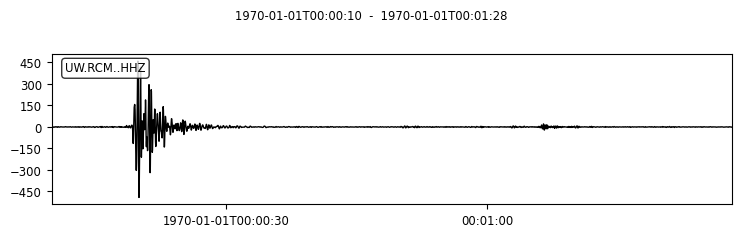

In [22]:
print(g)
print('*',g[1])
print(type(g[0]))
g[0].plot(); #plot the first part (the stream)

### Attempting reading from txt

In [ ]:
read_dict = []
# with open(f'/home/smocz/expand_redpy_new_files/eq_clusters{thresh_list[0]*100}-{thresh_list[-1]*100}.txt', 'w') as f: #save lists in txt file
with open(f'/home/smocz/expand_redpy_new_files/eq_clusters20.0-50.0.txt', 'w') as f: #save lists in txt file
    lines = f.readlines()
    for n,line in enumerate(lines): ### POSSIBLE SPLIT BY #, THEN LOOP THROUGH THOSE???? ###
        if line[0] == '#':
            label = line[1:]
        if line[0] != '#': #if not a label
            n_line = line[1:-1]
            sep_list = line.split('),') #get each tuple in the cluster
            tuple_list = [i+')' for i in sep_list]
            tuple_list = list([tuple(i) for i in line])
        read_dict[label] = tuple_list
        #remove first [0] and last [-1] character of each line, then split('),'), add ')' to the end of each term, then tuple(term)
        #put these into a list
        #append that list to the list for this cc value/label

In [16]:
line = '[(<obspy.core.stream.Stream object at 0x7f09f46aabb0>, \'rcmhhzrpra368\'), (<obspy.core.stream.Stream object at 0x7f09f4725760>, \'rcmhhzrpra409\')]'
if line[0] == '#':
    label = line[1:]
if line[0] != '#': #if not a label
    n_line = line[1:-1]
    sep_list = n_line.split('),') #get each tuple in the cluster
    print(sep_list)
    for t in n_sep_list:
        print(t)
        nt = t.replace('(','')
        nnt = nt.replace(')','')
        s = nnt.split(',')
        print('yo')
        print(s)
        print(type(s))
        print(s[1])
        break
#     tuple_list = list([tuple(t) for t in n_sep_list])


["(<obspy.core.stream.Stream object at 0x7f09f46aabb0>, 'rcmhhzrpra368'", " (<obspy.core.stream.Stream object at 0x7f09f4725760>, 'rcmhhzrpra409')"]
(<obspy.core.stream.Stream object at 0x7f09f46aabb0>, 'rcmhhzrpra368')
yo
['<obspy.core.stream.Stream object at 0x7f09f46aabb0>', " 'rcmhhzrpra368'"]
<class 'list'>
 'rcmhhzrpra368'


In [9]:
print(tuple_list)

[('(', '<', 'o', 'b', 's', 'p', 'y', '.', 'c', 'o', 'r', 'e', '.', 's', 't', 'r', 'e', 'a', 'm', '.', 'S', 't', 'r', 'e', 'a', 'm', ' ', 'o', 'b', 'j', 'e', 'c', 't', ' ', 'a', 't', ' ', '0', 'x', '7', 'f', '0', '9', 'f', '4', '6', 'a', 'a', 'b', 'b', '0', '>', ',', ' ', "'", 'r', 'c', 'm', 'h', 'h', 'z', 'r', 'p', 'r', 'a', '3', '6', '8', "'", ')'), (' ', '(', '<', 'o', 'b', 's', 'p', 'y', '.', 'c', 'o', 'r', 'e', '.', 's', 't', 'r', 'e', 'a', 'm', '.', 'S', 't', 'r', 'e', 'a', 'm', ' ', 'o', 'b', 'j', 'e', 'c', 't', ' ', 'a', 't', ' ', '0', 'x', '7', 'f', '0', '9', 'f', '4', '7', '2', '5', '7', '6', '0', '>', ',', ' ', "'", 'r', 'c', 'm', 'h', 'h', 'z', 'r', 'p', 'r', 'a', '4', '0', '9', "'", ')', ')')]


In [ ]:
# for groups in thresh_test:
groups = thresh_test[1]
print(' ')
print('#######################')
print(f'## THRESHOLD {thresh_list[thresh_test.index(groups)]}     ##')
print('#######################')
print(groups)
for gr in groups: #for each group
#     print(type(gr))
    if len(gr) > 1: #more than one tuple
        print('-----')
        print('index:',groups.index(gr))
        print('number of templates in group:',len(gr))
        for g in gr: #for each tuple
            print('*',g[2])
            obspy.read(g[1]).plot(); #plot the first part (the stream)


In [ ]:
for g in groups[57]:
    print('*',g[1])
    g[0].plot(); #plot the first part (the stream)

In [ ]:
print(len(groups[57]))

Figuring comparison between stations

I think there can be 3 outputs
1. conclusive - all (minsta?) stations have the the same grouping of clusters, everything is perfect. wow
2. inconclusive - doesn't make sense, no overlap that isn't just random
3. mostly conclusive - all (minsta?) stations SOME of the same grouping of clusters, enough that it's not random but isn't perfect


#### Now for the important part:
# How do we quantify these and process them?